In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib notebook
import matplotlib.pyplot as plt

# Visualizing the Data
## Matplotlib

              Player  Wingspan-in  Height-in  DWS Pos
0     Andre Drummond        90.25      81.75  5.7   C
1        Ben Simmons        83.50      82.00  5.0  PG
2      Anthony Davis        89.50      81.25  4.9  PF
3   Robert Covington        85.75      78.25  4.5  SF
4  Russell Westbrook        79.75      74.25  4.5  PG


<IPython.core.display.Javascript object>


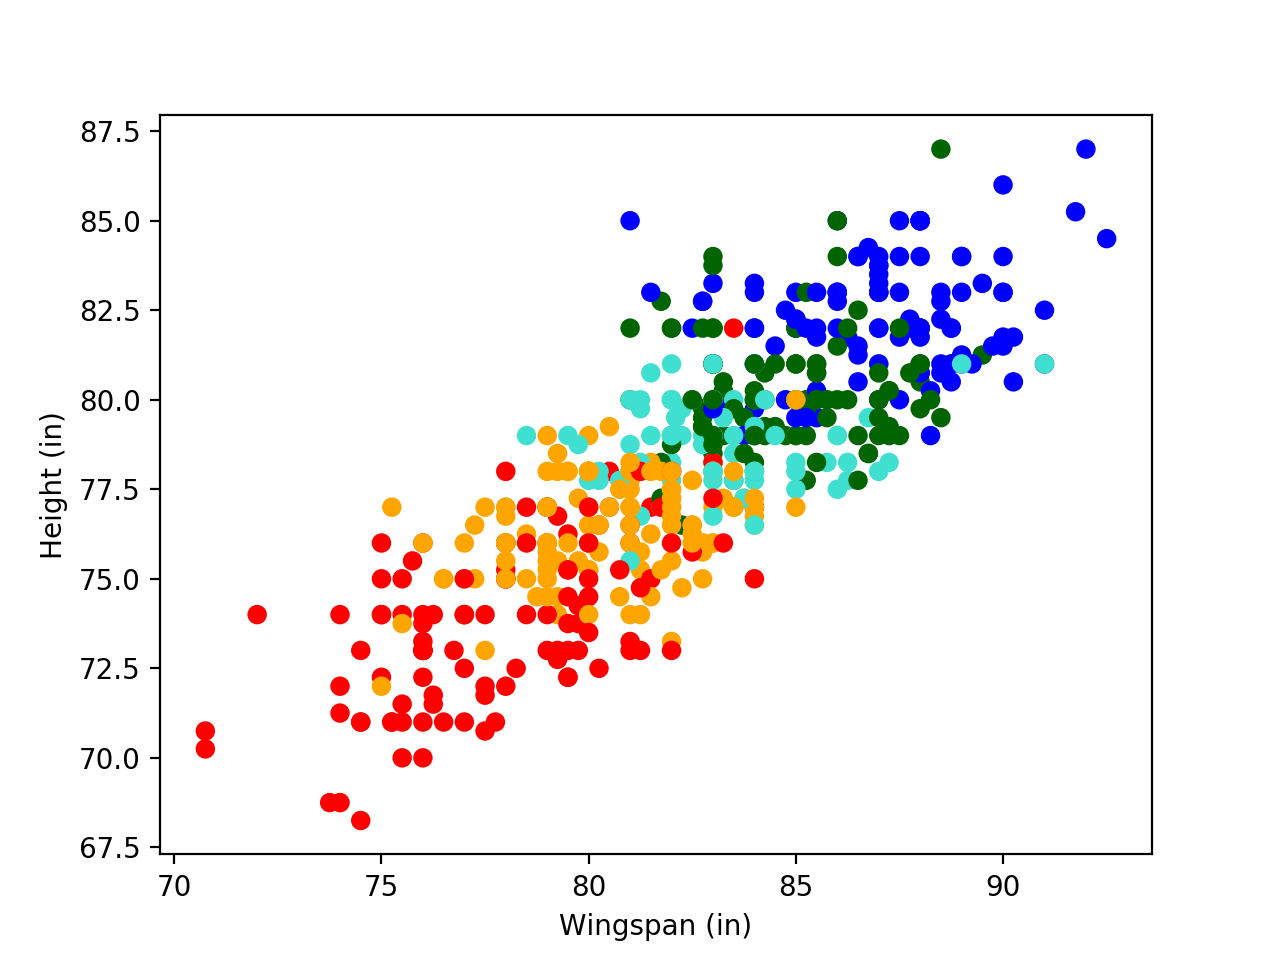

Text(0.5, 0, 'Wingspan (in)')

In [2]:
df = pd.read_csv("final-player-data-all.csv")
print(df.head())
color_dict = {'PG': 'red', 'SG': 'orange', 'SF':'turquoise', 
             'PF': 'darkgreen', 'C':'blue'}
fig, ax = plt.subplots(1,1)
ax.scatter(df[['Wingspan-in']], df[['Height-in']], c=df['Pos'].apply(lambda x: color_dict[x]))
ax.set_ylabel("Height (in)")
ax.set_xlabel("Wingspan (in)")

# Visualizing the Data
## Bokeh

In [3]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource, CDSView, GroupFilter,
                         HoverTool, CategoricalColorMapper)
from bokeh.layouts import gridplot
output_notebook()
cds = ColumnDataSource(df)
select_tools = ['box_select', 'pan', 'wheel_zoom', 'tap', 'reset']
color_mapper = CategoricalColorMapper(factors=['PG', 'SG', 'SF', 'PF', 'C'],
                                      palette=['red', 'orange', 'lightgreen', 'darkgreen', 'blue'])
fig = figure(x_axis_label='Wingspan(in)', y_axis_label='Height-in',
            plot_height=500, plot_width=500, tools=select_tools)
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, 
          color={'field':'Pos', 'transform':color_mapper})
hover_glyph = fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=12,
                        alpha=0, hover_fill_color='gray', hover_alpha=0.5)
tool_tips = [('Name', '@Player'),
            ('Pos', '@Pos'),
            ('Height', '@{Height-in}'),
            ('Wingspan', '@{Wingspan-in}')]
fig.add_tools(HoverTool(tooltips=tool_tips, renderers=[hover_glyph]))
show(fig)

Loading BokehJS ...

# Visualizing the data
## More complex Bokeh functionality

In [4]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource, CDSView, GroupFilter,
                         HoverTool, CategoricalColorMapper, GroupFilter)
from bokeh.layouts import gridplot
output_notebook()
cds = ColumnDataSource(df)
pg_view = CDSView(source=cds, filters=[GroupFilter(column_name='Pos', group='PG')])
sg_view = CDSView(source=cds, filters=[GroupFilter(column_name='Pos', group='SG')])
sf_view = CDSView(source=cds, filters=[GroupFilter(column_name='Pos', group='SF')])
pf_view = CDSView(source=cds, filters=[GroupFilter(column_name='Pos', group='PF')])
c_view = CDSView(source=cds, filters=[GroupFilter(column_name='Pos', group='C')])
select_tools = ['box_select', 'pan', 'wheel_zoom', 'tap', 'reset']
color_mapper = CategoricalColorMapper(factors=['PG', 'SG', 'SF', 'PF', 'C'],
                                      palette=['red', 'orange', 'lightgreen', 'darkgreen', 'blue'])
fig = figure(x_axis_label='Wingspan(in)', y_axis_label='Height-in',
            plot_height=500, plot_width=500, tools=select_tools)
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, view=pg_view,
          color='red', legend='PG')
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, view=sg_view,
          color='orange', legend='SG')
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, view=sf_view,
          color='lightgreen', legend='SF')
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, view=pf_view,
          color='darkgreen', legend='PF')
fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=10, view=c_view,
          color='blue', legend='C')
hover_glyph = fig.circle(x='Wingspan-in', y='Height-in', source=cds, size=12,
                        alpha=0, hover_fill_color='gray', hover_alpha=0.5)
tool_tips = [('Name', '@Player'),
            ('Pos', '@Pos'),
            ('Height', '@{Height-in}'),
            ('Wingspan', '@{Wingspan-in}')]
fig.add_tools(HoverTool(tooltips=tool_tips, renderers=[hover_glyph]))
fig.legend.click_policy = 'hide'
fig.legend.location = 'top_left'
show(fig)

Loading BokehJS ...

# Apply some ML techniques to try to predict position off wingspan and height

### Define the test-train split

In [5]:
X = df[['Wingspan-in','Height-in']]
Y = df['Pos']
x_train, x_test, y_train, y_test = train_test_split(df[['Wingspan-in', 'Height-in']], df['Pos'])

### Make a utility function for quickly plotting and comparing
We'll be doing a simple scatter plot over all the data, coloring based on position

But we'll overlay a colormesh based on the predicted position

In [6]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import numpy as np

color_map = {'PG': '#FF0000', 'SG':'#00FF00', 'SF':'#0000FF', 'PF':'#AFAFAF',
            'C':'#800080'}

def map_array(Z):
    new_mat = []
    val_pos_map = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}
    for row in Z:
        new_mat.extend(val_pos_map[val] for val in row)
    new_mat = np.array(new_mat).reshape(Z.shape)
    return new_mat

def plot_pos_model(X, y, clf):
    X_mat = X[['Wingspan-in', 'Height-in']].values
    y_mat = y.values
    
    cmap_light = ListedColormap(['#7F0000', '#007F00', '#00007F','#575757', '#400040'])
    
    mesh_step_size=0.1
    plot_symbol_size=50
    
    x_min, x_max = X_mat[:,0].min() -1, X_mat[:,0].max()+1
    y_min, y_max = X_mat[:,1].min() -1, X_mat[:,1].max()+1
    xx,yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                       np.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    new_mat = map_array(Z)
    plt.figure()
    #plt.pcolormesh(xx,yy, Z)
    keys, vals = np.unique(Z, return_inverse=True)
    vals = vals.reshape(xx.shape)
    plt.pcolormesh(xx,yy, new_mat, cmap=cmap_light)
    
    plt.scatter(X_mat[:,0], X_mat[:,1], s=plot_symbol_size, c=[color_map[a] for a in y_mat], edgecolor='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    patch0 = mpatches.Patch(color='#FF0000', label='PG')
    patch1 = mpatches.Patch(color='#00FF00', label='SG')
    patch2 = mpatches.Patch(color='#0000FF', label='SF')
    patch3 = mpatches.Patch(color='#AFAFAF', label='PF')
    patch4 = mpatches.Patch(color='#800080', label='C')
    plt.legend(handles=[patch0, patch1, patch2, patch3, patch4], ncol=2)
    
    
    plt.xlabel('wingspan (in)')
    plt.ylabel('height (in)')
    plt.show()
#plot_pos_model(X, Y, clf)


0.4617283950617284
0.4148148148148148


/Users/ayang41/anaconda3/envs/personal_37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ayang41/anaconda3/envs/personal_37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<IPython.core.display.Javascript object>


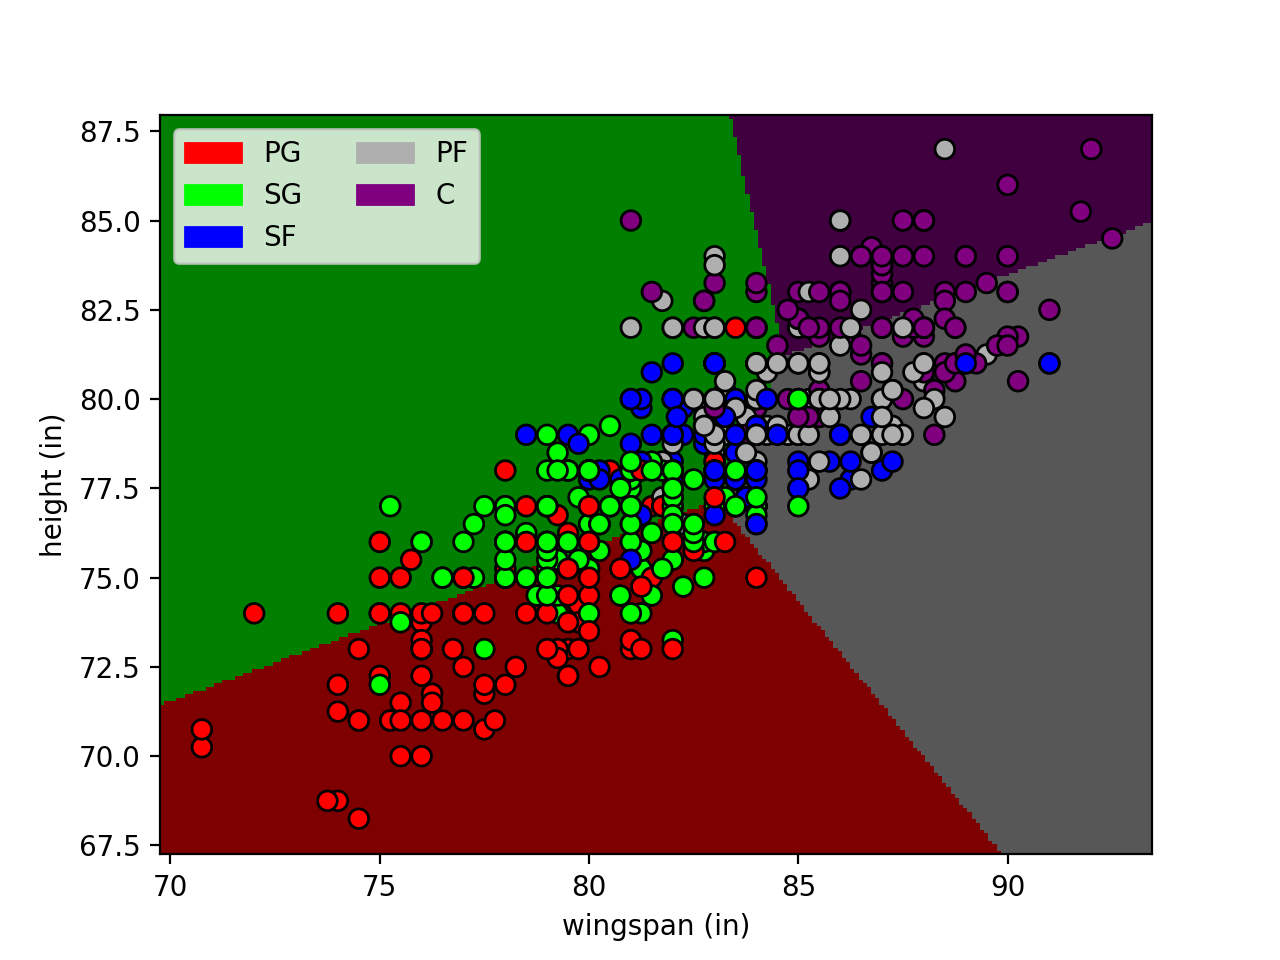

In [7]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print(logreg.score(x_train, y_train))
print(logreg.score(x_test, y_test))
plot_pos_model(X, Y, logreg)

0.8962962962962963
0.48148148148148145


<IPython.core.display.Javascript object>


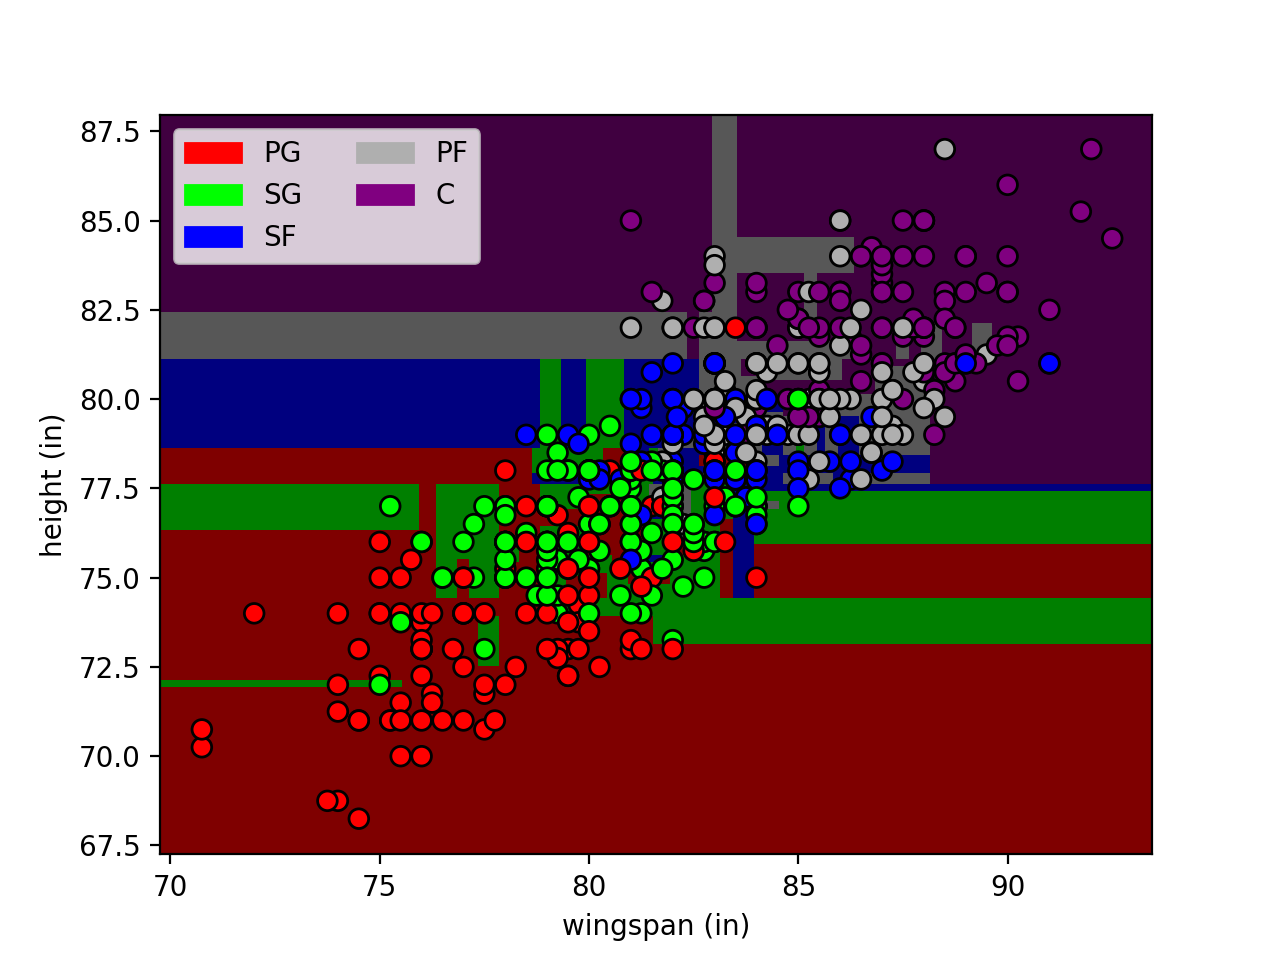

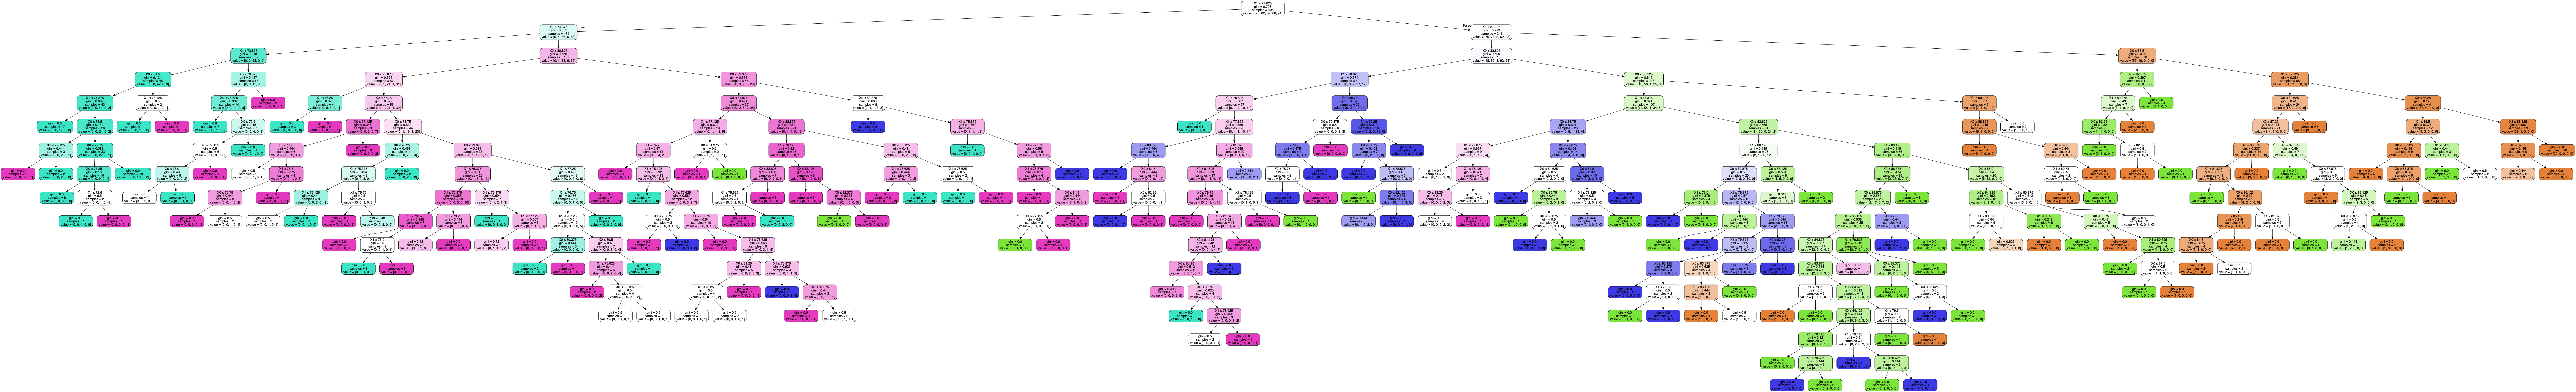

In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

plot_pos_model(X,Y,clf)
# Additional code to visualize the decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

0.7037037037037037
0.5555555555555556


<IPython.core.display.Javascript object>


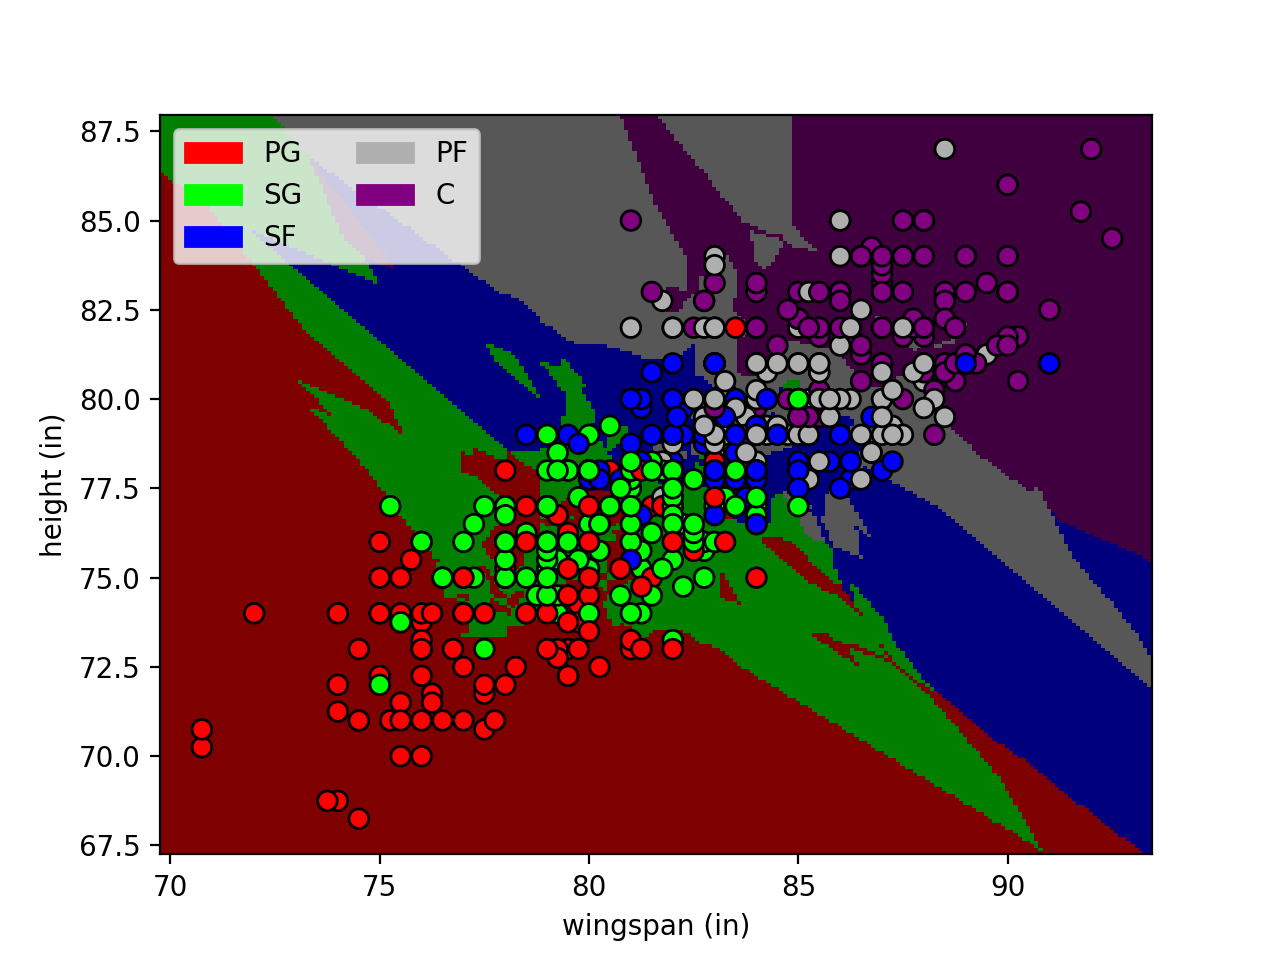

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
print(knn.score(x_train, y_train))
print(knn.score(x_test, y_test))
plot_pos_model(X, Y, knn)

0.6444444444444445
0.6814814814814815


<IPython.core.display.Javascript object>


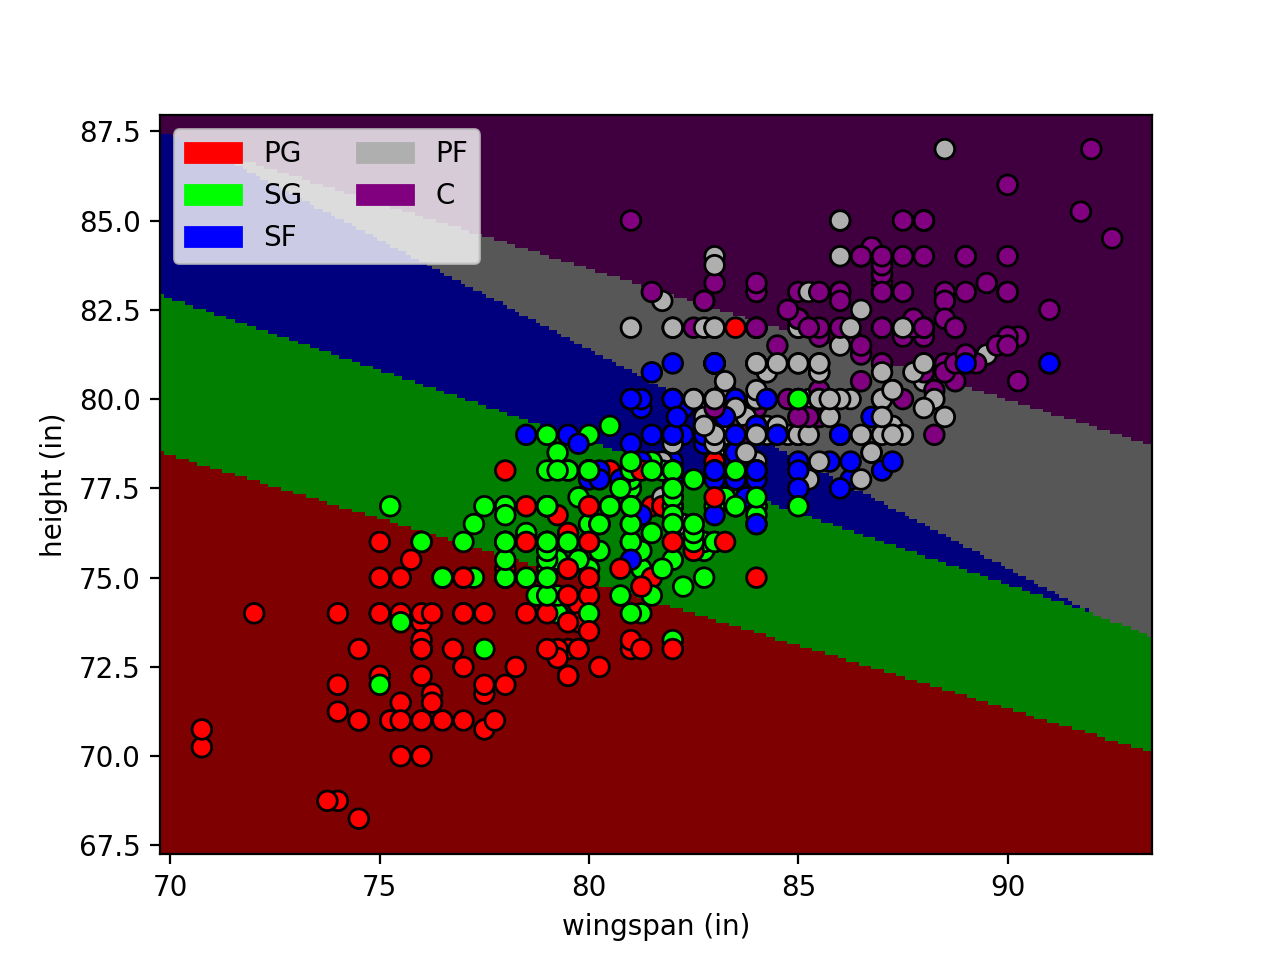

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
print(lda.score(x_train, y_train))
print(lda.score(x_test, y_test))
plot_pos_model(X, Y, lda)

0.6444444444444445
0.6296296296296297


<IPython.core.display.Javascript object>


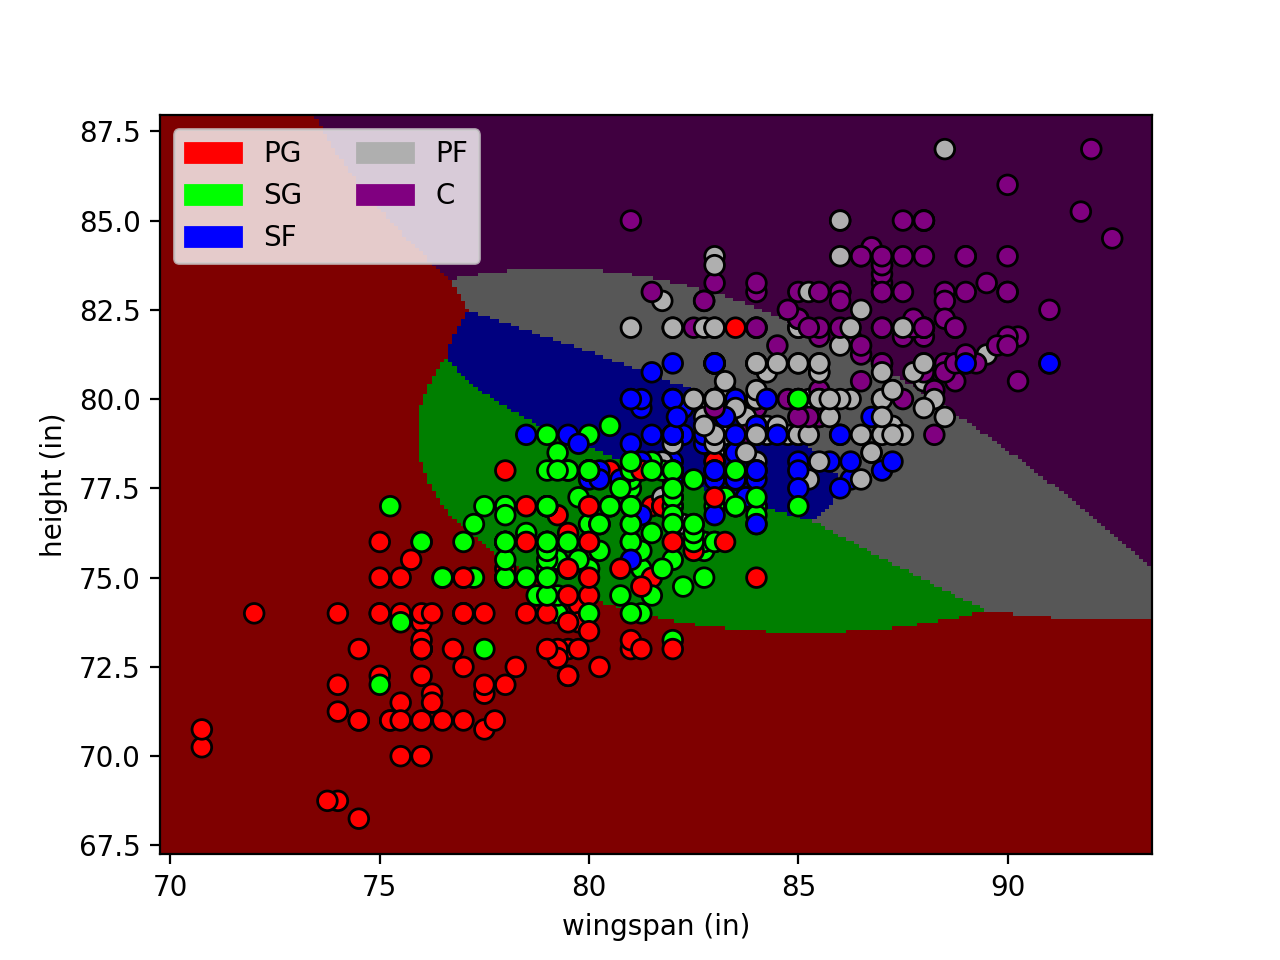

In [11]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
print(gnb.score(x_train, y_train))
print(gnb.score(x_test, y_test))
plot_pos_model(X, Y, gnb)

/Users/ayang41/anaconda3/envs/personal_37/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.691358024691358
0.6370370370370371


<IPython.core.display.Javascript object>


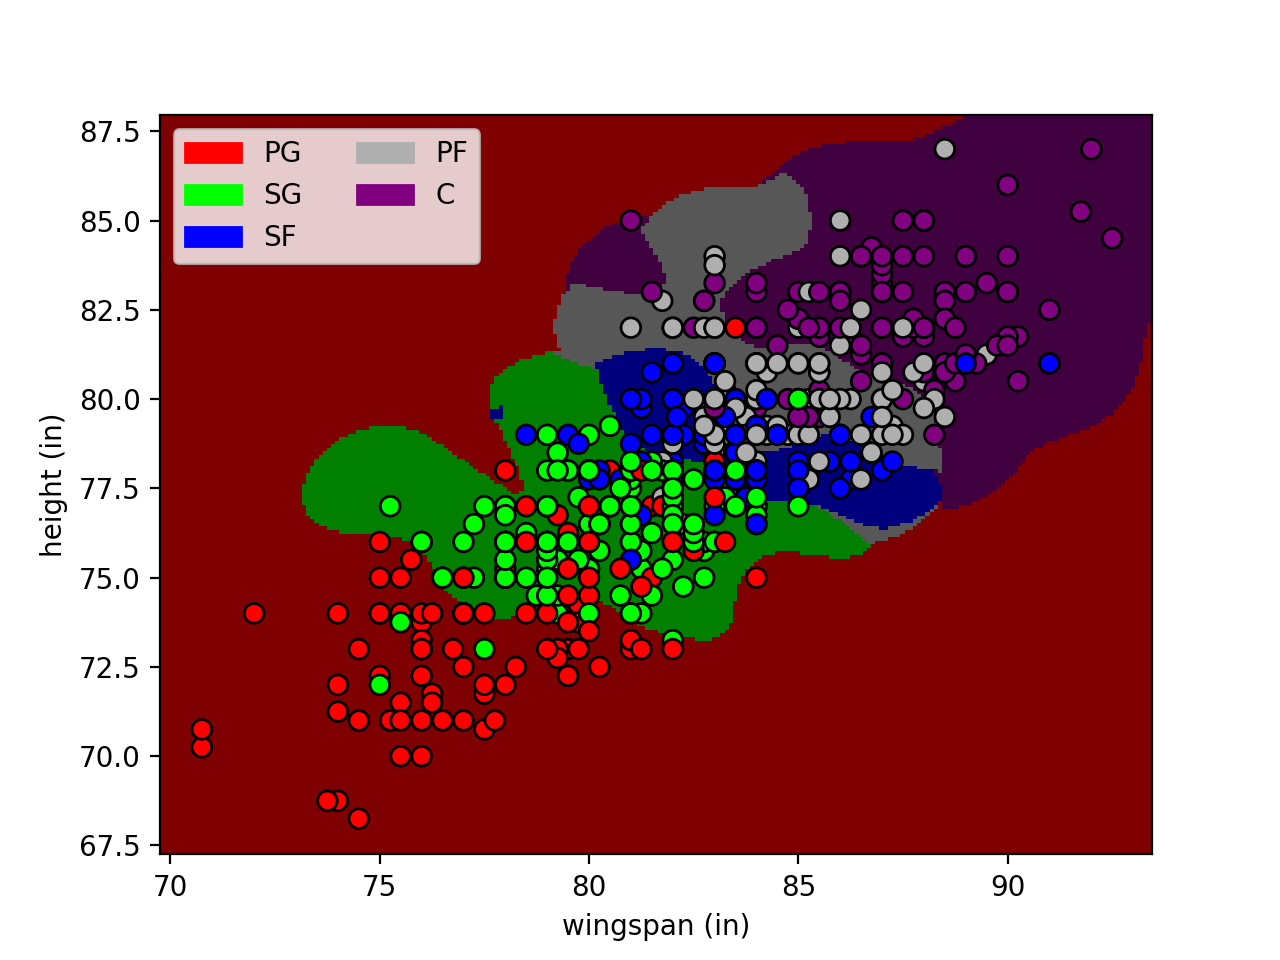

In [12]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(x_train, y_train)
print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))
plot_pos_model(X, Y, svm)